In [17]:
import re

def clean_text(filename):
    with open("data/" + filename, 'r', encoding='utf-8') as file:
        book_text = file.read()

    cleaned_text = re.sub(r'\n+', ' ', book_text) # 줄바꿈을 빈칸으로 변경
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text) # 여러 빈칸을 하나의 빈칸으로

    print("data/cleaned_" + filename, len(cleaned_text), "characters") # 글자 수 출력

    with open("data/cleaned_" + filename, 'w', encoding='utf-8') as file:
        file.write(cleaned_text)

filenames_list = ["02 Harry Potter and the Chamber of Secrets.txt"]

for filename in filenames_list:
    clean_text(filename)

data/cleaned_02 Harry Potter and the Chamber of Secrets.txt 488771 characters


##  토큰화

In [18]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

text = "  which Harry watched fly around the room wishing he still had his fulls"

tokens = tokenizer.encode(text)

print("글자수 :", len(text))  # 글자수: 26
print("토큰수 :", len(tokens))  # 토큰수: 6
print(tokens)  # [15496, 2159, 257, 281, 3453, 13]
print(tokenizer.decode(tokens))  # Harry Potter was a wizard.
for token in tokens:
    print(token, ":", tokenizer.decode([token]))

글자수 : 72
토큰수 : 15
[220, 543, 5850, 7342, 6129, 1088, 262, 2119, 24433, 339, 991, 550, 465, 1336, 82]
  which Harry watched fly around the room wishing he still had his fulls
220 :  
543 :  which
5850 :  Harry
7342 :  watched
6129 :  fly
1088 :  around
262 :  the
2119 :  room
24433 :  wishing
339 :  he
991 :  still
550 :  had
465 :  his
1336 :  full
82 : s


### 한글 사용시 해당 토크나이저 사용

In [3]:
# from transformers import AutoTokenizer

# # tokenizer = AutoTokenizer.from_pretrained("LGAI-EXAONE/ExaOne-3.5-7.8B-Instruct")
# tokenizer = AutoTokenizer.from_pretrained("skt/kogpt2-base-v2")

# print("Vocab size:", tokenizer.vocab_size)

# text = "해리 포터는 마법사였다."

# tokens = tokenizer.encode(text)

# print("글자수 :", len(text))  # 글자수: 14
# print("토큰수 :", len(tokens))  # 토큰수: 10
# print(tokens)
# print(tokenizer.decode(tokens))


In [19]:
import torch
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):
    def __init__(self, txt, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # token_ids = tokenizer.encode("<|endoftext|>" + txt, allowed_special={"<|endoftext|>"})
        token_ids = tokenizer.encode(txt)

        print("# of tokens in txt:", len(token_ids))

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

        
attention_mask 나중에 참고해야 할듯
```python
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        return input_ids, attention_mask
```

In [20]:
with open("data/cleaned_02 Harry Potter and the Chamber of Secrets.txt", "r", encoding="utf-8") as f:
    txt = f.read()

# dataset = MyDataset(txt, max_length=512, stride=256)

dataset = MyDataset(txt, max_length=32, stride=4)

train_loader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

# test, valid는 생략


# of tokens in txt: 130520


In [21]:
dataiter = iter(train_loader)

x, y = next(dataiter)

print(tokenizer.decode(x[0].tolist()))
print(tokenizer.decode(y[0].tolist()))

 all we’ve got is a lousy old ghoul in the attic and gnomes all over the garden. House-elves come with big old man
 we’ve got is a lousy old ghoul in the attic and gnomes all over the garden. House-elves come with big old manors


## 모델 정의

In [22]:
VOCAB_SIZE = tokenizer.n_vocab
CONTEXT_LENGTH = 128
EMB_DIM = 768
NUM_HEADS = 12
NUM_LAYERS = 12
DROP_RATE = 0.1
QKV_BIAS = False

In [23]:
import torch.nn as nn

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        
        assert d_out % NUM_HEADS == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.head_dim = d_out // NUM_HEADS

        self.W_query = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_key = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.W_value = nn.Linear(d_in, d_out, bias=QKV_BIAS)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(DROP_RATE)
        self.register_buffer('mask', torch.triu(torch.ones(CONTEXT_LENGTH, CONTEXT_LENGTH), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        keys = keys.view(b, num_tokens, NUM_HEADS, self.head_dim)
        values = values.view(b, num_tokens, NUM_HEADS, self.head_dim)
        queries = queries.view(b, num_tokens, NUM_HEADS, self.head_dim)

        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        attn_scores = queries @ keys.transpose(2, 3)

        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = (attn_weights @ values).transpose(1, 2)

        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(EMB_DIM, 4 * EMB_DIM),
            GELU(),
            nn.Linear(4 * EMB_DIM, EMB_DIM),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=EMB_DIM,
            d_out=EMB_DIM)
    
        self.ff = FeedForward()
        self.norm1 = LayerNorm(EMB_DIM)
        self.norm2 = LayerNorm(EMB_DIM)
        self.drop_shortcut = nn.Dropout(DROP_RATE)

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x


class GPTModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.tok_emb = nn.Embedding(VOCAB_SIZE, EMB_DIM)
        self.pos_emb = nn.Embedding(CONTEXT_LENGTH, EMB_DIM)
        self.drop_emb = nn.Dropout(DROP_RATE)

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock() for _ in range(NUM_LAYERS)])

        self.final_norm = LayerNorm(EMB_DIM)
        self.out_head = nn.Linear(EMB_DIM, VOCAB_SIZE, bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [24]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

torch.manual_seed(123)
model = GPTModel()
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

cuda


In [25]:
tokens_seen, global_step = 0, -1

losses = []

for epoch in range(10):
    model.train()  # Set model to training mode
    
    epoch_loss = 0
    for input_batch, target_batch in train_loader:
        optimizer.zero_grad() # Reset loss gradients from previous batch iteration
        input_batch, target_batch = input_batch.to(device), target_batch.to(device)

        logits = model(input_batch)
        loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
        epoch_loss += loss.item()
        loss.backward() # Calculate loss gradients
        optimizer.step() # Update model weights using loss gradients
        tokens_seen += input_batch.numel()
        global_step += 1

        if global_step % 1000 == 0:
            print(f"Tokens seen: {tokens_seen}")
        # Optional evaluation step

    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch: {epoch + 1}, Loss: {avg_loss}")
    torch.save(model.state_dict(), "model_" + str(epoch + 1).zfill(3) + ".pth")

# 주의: 여기서는 편의상 모든 데이터를 train에 사용하였습니다. 
#      ML에서는 일부 데이터를 validation에 사용하는 것이 일반적입니다.

Tokens seen: 4096
Epoch: 1, Loss: 4.3979428114853505
Epoch: 2, Loss: 2.2266207938119185
Epoch: 3, Loss: 0.7970686458696531
Tokens seen: 4100096
Epoch: 4, Loss: 0.39226424870059245
Epoch: 5, Loss: 0.304862799489592
Epoch: 6, Loss: 0.27067149131316837
Epoch: 7, Loss: 0.253944440854816
Tokens seen: 8196096
Epoch: 8, Loss: 0.2433952234509423
Epoch: 9, Loss: 0.2368674221353268
Epoch: 10, Loss: 0.23027527848566612


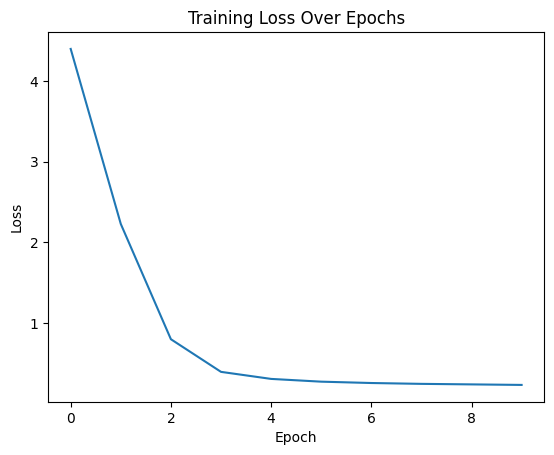

In [27]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

In [28]:
model.load_state_dict(torch.load("model_010.pth", map_location=device, weights_only=True))
model.eval() # dropout X

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(128, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [29]:
test = "Dobby is"
idx = tokenizer.encode(test)
idx = torch.tensor(idx).unsqueeze(0).to(device)

with torch.no_grad():
    logits = model(idx)

logits = logits[:, -1, :]

# 가장 확률이 높은 단어 10개 출력
top_logits, top_indices = torch.topk(logits, 10) 
for p, i in zip(top_logits.squeeze(0).tolist(), top_indices.squeeze(0).tolist()):
    print(f"{p:.2f}\t {i}\t {tokenizer.decode([i])}")

# 가장 확률이 높은 단어 출력
idx_next = torch.argmax(logits, dim=-1, keepdim=True)
flat = idx_next.squeeze(0) # 배치 차원 제거 torch.Size([1])
out = tokenizer.decode(flat.tolist()) # 텐서를 리스트로 바꿔서 디코드
print(out)

12.66	 257	  a
9.43	 991	  still
9.04	 46258	  valiant
8.78	 284	  to
8.55	 4978	  caught
8.19	 30	 ?
8.09	 4762	  believed
8.06	 10597	  till
8.05	 1479	  free
7.96	 262	  the
 a


In [30]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [32]:
start_context = input("Start context: ")

# idx = tokenizer.encode(start_context, allowed_special={'<|endoftext|>'})
idx = tokenizer.encode(start_context)
idx = torch.tensor(idx).unsqueeze(0)

context_size = model.pos_emb.weight.shape[0] 

for i in range(10):

    token_ids = generate(
        model=model,
        idx=idx.to(device),
        max_new_tokens=50,
        context_size= context_size,
        top_k=50,
        temperature=0.5
    )

    flat = token_ids.squeeze(0) # remove batch dimension
    out = tokenizer.decode(flat.tolist()).replace("\n", " ")

    print(i, ":", out)

0 : Dobby is a house-elf.…” “What does this mean, Albus?” Professor McGonagall asked urgently. “It means finding out Veronica Sm to the whole body sort of Gryffindor dormitwick let out
1 : Dobby is a house-elf.…” said Harry. “Well, whoever owns him will be an old wizarding family, and they’ll be ready to be rich,’ll be rich,’ll be rich,�
2 : Dobby is a house-elf.…” The voice was growing fainter. Harry was sure it was moving away — moving upward. A mixture of fear spreading up to bewattle cauldron was that he looked dream team how it was stretched out
3 : Dobby is a house-elf.…” The voice was growing fainter. Harry was sure it was moving away — moving upward. A mixture of fear spreading up to beaming once more curious people kept waking in the whole body of fear spreading up
4 : Dobby is a house-elf.…” said Harry. “Well, whoever owns him will be an old wizarding family, and they’ll be ready to be rich,” said it’ll be rich, as quickly st
5 : Dobby is a house-elf.…” The voice was growing 